# Toy EA for generalization
An EA for the hyperparameter tuning of a NN. 
The goal is to make it general w.r.t. the model and the set of hyperparamter chosen. 

NN Parameters to be optimized:
- learning rate 
- number of layers
- number of units (one different value for each layer)
- dropout 

In [61]:
# Library imports
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from tqdm.notebook import tqdm

In [62]:
# Configura il dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
# Caricamento e pre-elaborazione del dataset MNIST

all_data = False

if all_data:
    # Compose permette di concatenare più trasformazioni
    # ToTensor() converte l'immagine in un tensore (utile per operazioni matematiche) -> porta i pixel da [0, 255] a [0, 1]
    # Normalize() normalizza i pixel dell'immagine -> porta i pixel da [0, 1] a [-1, 1] (normalizza i dati usando media 0.5 e deviazione standard 0.5)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    # Caricamento del dataset MNIST
    # root = './data' indica la cartella in cui scaricare il dataset
    # train = True estrae il dataset di training (il MNIST ha entrambi i dataset)
    # transform = transform applica le trasformazioni definite sopra
    # download = True scarica il dataset se non è già presente
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    # Caricamento dei dati nel DataLoader (serve per caricare i dati in batch)
    # batch_size = 32 indica quante immagini caricare in ogni batch
    # shuffle = True indica che i dati vengono caricati in ordine casuale
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
else:
    # Caricamento e pre-elaborazione del dataset MNIST
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Caricamento del dataset completo
    full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    full_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    # Percentuale di dati da utilizzare (20% per il training, 10% per il test)
    train_subset_size = int(0.2 * len(full_train_dataset))
    test_subset_size = int(0.1 * len(full_test_dataset))

    # Genera indici casuali per il sottoinsieme
    # len(full_train_dataset) è l'intervallo di numeri da cui scegliere (con lo 0 incluso, len escluso)
    # train_subset_size è il numero di elementi da scegliere
    # replace=False indica che NON si possono scegliere due volte lo stesso elemento
    train_indices = np.random.choice(len(full_train_dataset), train_subset_size, replace=False)
    test_indices = np.random.choice(len(full_test_dataset), test_subset_size, replace=False)

    # Crea i sottoinsiemi
    # Subset permette di creare un sottoinsieme di un dataset dato un insieme di indici
    train_subset = Subset(full_train_dataset, train_indices)
    test_subset = Subset(full_test_dataset, test_indices)

    # Carica i sottoinsiemi nel DataLoader
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


In [64]:
class MNISTModel(nn.Module):
    def __init__(self, learning_rate, num_units_array, dropout_rate):
        super(MNISTModel, self).__init__()
        self.learning_rate = learning_rate
        self.num_units_array = num_units_array
        self.dropout_rate = dropout_rate
        self.num_layers = len(num_units_array)

        # Costruzione della rete neurale
        layers = [nn.Flatten()]
        layers.append(nn.Linear(28 * 28, num_units_array[0]))
        layers.append(nn.ReLU())

        if self.num_layers > 1:
            for i in range(self.num_layers - 1):
                layers.append(nn.Linear(num_units_array[i], num_units_array[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(self.dropout_rate))
        
        layers.append(nn.Linear(num_units_array[-1], 10))  # Output finale
        self.model = nn.Sequential(*layers)
        
        # Ottimizzatore
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def train_model(self):
        self.train()  # Modalità training
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            self.optimizer.zero_grad()
            output = self(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

    def evaluate(self):
        self.eval()  # Modalità evaluation
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = self(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / len(test_loader.dataset)
        return accuracy


In [65]:
def fitness_assessment(solution, model_class, num_epochs):
    """
    Valuta la fitness di una soluzione, istanziando il modello con i parametri dati.
    
    Args:
    - solution (dict): Dizionario con i parametri della rete.
    - model_class (class): Classe del modello della rete neurale (deve avere un metodo `evaluate`).

    Returns:
    - float: Accuratezza della rete sul set di test, utilizzata come fitness.
    """
    # Istanzia il modello con la configurazione specificata dalla soluzione
    # **solution converte il dizionario in argomenti chiave-valore, in modo da passare i parametri come argomenti
    model = model_class(**solution).to(device)  # Assicurati di spostare il modello sul dispositivo corretto (CPU o GPU)
    
    # Fase di training del modello per alcune epoche
    for _ in range(num_epochs):  # Training per 3 epoche, può essere aumentato se il task richiede più iterazioni
        #print("Start training for fitness assessment")
        model.train_model()
    
    # Calcola la fitness come accuratezza sul set di test
    accuracy = model.evaluate()  # Restituisce l'accuratezza della rete neurale
    return accuracy


def create_genotype(params_config):
    genotype = {}
    for param, config in params_config.items():
        if param == "num_units_array":
            # Genera `num_units_array` basandoti sul numero di layer generato
            num_layers = random.choice(range(config["num_layers_range"][0], config["num_layers_range"][1] + 1))
            genotype[param] = [random.randint(*config["range"]) for _ in range(num_layers)]
        else:
            genotype[param] = random.uniform(*config["range"])
    return genotype





# Funzione per convertire il genotipo in una soluzione
def genotype_to_solution(genotype, params_config):
    solution = {}
    for param, value in genotype.items():
        if param == "num_units_array":
            solution[param] = [int(round(val)) for val in value]
            continue
        if params_config[param].get("to_int", False):  # Converte a intero se specificato
            solution[param] = int(round(value))
        else:
            solution[param] = value
    return solution

# Funzione di crossover generale che usa l'operatore specificato per ciascun parametro
def crossover(parent1, parent2, params_config):
    child = {}
    for param in parent1.keys():
        if param == "num_units_array":
            child[param] = [uniform_crossover(val1, val2) for val1, val2 in zip(parent1[param], parent2[param])]
            continue # Salta il resto della funzione e passa al prossimo ciclo
        crossover_func = params_config[param].get("crossover", uniform_crossover)  # Operatore di default
        child[param] = crossover_func(parent1[param], parent2[param])
    return child

def mutate(genotype, params_config, mutation_rate=0.1):
    for param, value in genotype.items():
        if random.random() < mutation_rate:
            if param == "num_units_array":
                # Aggiorna solo i valori di `num_units` esistenti
                genotype[param] = [random.randint(*params_config["num_units_array"]["range"]) for _ in range(round(len(genotype["num_units_array"])))]
            else:
                mutation_func = params_config[param].get("mutation", random_mutation)
                genotype[param] = mutation_func(value, params_config[param]["range"])
    return genotype


# Operatori di crossover e mutazione di esempio
def uniform_crossover(val1, val2):
    return val1 if random.random() < 0.5 else val2

def random_mutation(value, value_range):
    return random.uniform(*value_range)


# Funzione per eseguire l'algoritmo genetico
def evolutionary_algorithm(model_class, params_config, population_size, generations, num_epochs):
    # Inizializza la popolazione (genotipi)
    population = [create_genotype(params_config) for _ in range(population_size)]
    #print("Popolazione iniziale")
    #for genotype in population:
    #    print(genotype)

    for generation in tqdm(range(generations), desc="Generazioni"):
        print(f"Generazione {generation + 1}")

        # Valutazione fitness con barra di avanzamento
        scores = []
        for genotype in tqdm(population, desc="Valutazione Fitness"):
           solution = genotype_to_solution(genotype, params_config)
           fitness = fitness_assessment(solution, model_class, num_epochs)
           scores.append((genotype, fitness))

        scores.sort(key=lambda x: x[1], reverse=True)

        # Selezione dei migliori genotipi
        top_individuals = scores[:population_size // 2]

        # Crossover e Mutazione per generare nuovi individui
        new_population = []
        for i in range(population_size // 2):
            parent1, parent2 = random.sample(top_individuals, 2)
            child_genotype = crossover(parent1[0], parent2[0], params_config)
            mutated_child = mutate(child_genotype, params_config)
            new_population.append(mutated_child)

        # Aggiorna la popolazione con i migliori e i nuovi individui
        population = [ind[0] for ind in top_individuals] + new_population
        #print("Poplazione:")
        #for genotype in population:
        #    print(genotype)

    # Restituisce l'individuo migliore
    best_genotype = max(population, key=lambda ind: fitness_assessment(genotype_to_solution(ind, params_config), model_class, num_epochs))
    best_solution = genotype_to_solution(best_genotype, params_config)
    return best_solution



In [66]:
# Esempio di configurazione parametri
params_config = {
    'learning_rate': {
        "range": (0.0001, 0.1),
        "crossover": uniform_crossover,
        "mutation": random_mutation,
        "array": False,
        "to_int": False
    },
    'num_units_array': {
        "range": (36,128),
        "crossover": uniform_crossover,
        "mutation": random_mutation,
        "array": True,
        "to_int": True,  # Converte il valore a intero per la soluzione
        "num_layers_range": (1, 4)
    },
    'dropout_rate': {
        "range": (0.0, 0.5),
        "crossover": uniform_crossover,
        "mutation": random_mutation,
        "array": False,
        "to_int": False
    }
}

best_params = evolutionary_algorithm(MNISTModel, params_config, population_size=10, generations=5, num_epochs=5)
print("Migliori parametri trovati:", best_params)

Generazioni:   0%|          | 0/5 [00:00<?, ?it/s]

Generazione 1


Valutazione Fitness:   0%|          | 0/10 [00:00<?, ?it/s]

Generazione 2


Valutazione Fitness:   0%|          | 0/10 [00:00<?, ?it/s]

Generazione 3


Valutazione Fitness:   0%|          | 0/10 [00:00<?, ?it/s]

Generazione 4


Valutazione Fitness:   0%|          | 0/10 [00:00<?, ?it/s]

Generazione 5


Valutazione Fitness:   0%|          | 0/10 [00:00<?, ?it/s]

Migliori parametri trovati: {'learning_rate': 0.001839069243251493, 'num_units_array': [110], 'dropout_rate': 0.1012229423086925}


In [79]:
# Funzione aggiornata per addestrare il modello e tracciare train e validation loss
def train_and_evaluate_model(params, model_class, epochs):
    model = model_class(**params).to(device)
    
    train_losses = []
    validation_losses = []

    # Loop di addestramento per ciascuna epoca
    for epoch in range(epochs):
        model.train()  # Modalità di training
        epoch_train_loss = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            model.optimizer.zero_grad()
            output = model(data)
            loss = model.criterion(output, target)
            loss.backward()
            model.optimizer.step()
            epoch_train_loss += loss.item()

        # Calcola la media della train loss per l'epoca corrente
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # Calcolo della validation loss
        model.eval()  # Modalità di valutazione
        epoch_val_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = model.criterion(output, target)
                epoch_val_loss += loss.item()

        # Calcola la media della validation loss per l'epoca corrente
        epoch_val_loss /= len(test_loader)
        validation_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Calcolo dell'accuratezza finale sul test set
    final_accuracy = model.evaluate()

    return final_accuracy, train_losses, validation_losses


# Parametri standard di base (baseline)
baseline_params = {
    'learning_rate': 0.001,
    'num_units_array': [128],
    'dropout_rate': 0.2
}

num_epochs_test = 5

print("baseline_params", baseline_params)
print("best_params", best_params)

# 1. Test del modello con i parametri standard (baseline)
print("\nTesting baseline model with standard parameters...")
baseline_accuracy, baseline_train_losses, baseline_val_losses = train_and_evaluate_model(baseline_params, MNISTModel, epochs=num_epochs_test)
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

# 2. Test del modello con i parametri ottimizzati dall'algoritmo evolutivo
print("\nTesting model with optimized parameters...")
optimized_accuracy, optimized_train_losses, optimized_val_losses = train_and_evaluate_model(best_params, MNISTModel, epochs=num_epochs_test)
print(f"Optimized accuracy: {optimized_accuracy:.4f}")




baseline_params {'learning_rate': 0.01, 'num_units_array': [128], 'dropout_rate': 0.2}
best_params {'learning_rate': 0.001839069243251493, 'num_units_array': [110], 'dropout_rate': 0.1012229423086925}

Testing baseline model with standard parameters...
Epoch 1/5, Train Loss: 0.6319, Validation Loss: 0.3310
Epoch 2/5, Train Loss: 0.3851, Validation Loss: 0.3573
Epoch 3/5, Train Loss: 0.3472, Validation Loss: 0.3157
Epoch 4/5, Train Loss: 0.3381, Validation Loss: 0.2897
Epoch 5/5, Train Loss: 0.3353, Validation Loss: 0.3432
Baseline accuracy: 0.9150


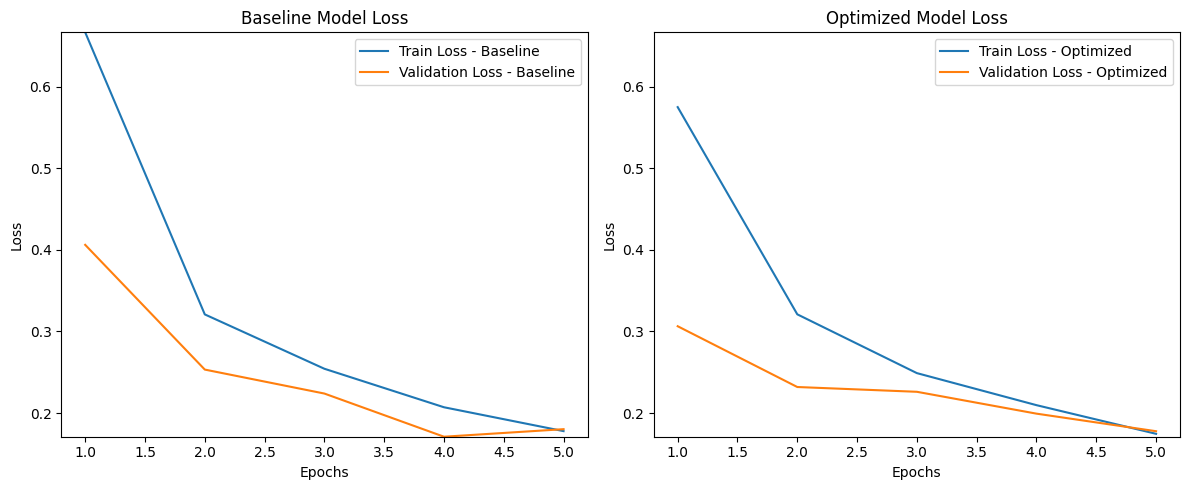

In [70]:
# Visualizzazione dei risultati con assi vincolati
epochs = range(1, len(baseline_train_losses) + 1)

# Trova i limiti comuni per l'asse y (perdita)
all_losses = baseline_train_losses + baseline_val_losses + optimized_train_losses + optimized_val_losses
y_min, y_max = min(all_losses), max(all_losses)

# Grafico della perdita per i parametri baseline
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, baseline_train_losses, label='Train Loss - Baseline')
plt.plot(epochs, baseline_val_losses, label='Validation Loss - Baseline')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Baseline Model Loss')
plt.legend()
plt.ylim(y_min, y_max)  # Imposta i limiti y comuni

# Grafico della perdita per i parametri ottimizzati
plt.subplot(1, 2, 2)
plt.plot(epochs, optimized_train_losses, label='Train Loss - Optimized')
plt.plot(epochs, optimized_val_losses, label='Validation Loss - Optimized')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Optimized Model Loss')
plt.legend()
plt.ylim(y_min, y_max)  # Imposta i limiti y comuni

plt.tight_layout()
plt.show()
